# Analysis for the experiments on the SINC scenario

In [1]:
# Import all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Settings
fileName = "resultsSINC.csv"
orderingStrategyPMedici = "IN_ORDER_SIZE_DESC"

In [3]:
# Load the file into a pandas dataframe
df = pd.read_csv(fileName, names=['Generator','ModelName','PercentageOfOldTsKept','TSSize','TSTime','Strength','Ordering',''], header=0, index_col=False)
# Set Ordering to empty string where it is NaN
df['Ordering'].fillna('', inplace=True)

## Group all executions

In [7]:
# Group data in df by Generator, ModelName, PercentageOfOldTsKept, Strength, and Ordering. For the TSSize and TS time, take the mean
df = df.groupby(['Generator','ModelName','PercentageOfOldTsKept','Strength','Ordering']).agg({'TSSize':'mean', 'TSTime':'mean'}).reset_index()
# Remove from df all the lines where generator is pMEDICI or pMEDICI+ but Ordering is not equal to orderingStrategyPMedici
dfFiltered = df[~(df['Generator'].str.contains('pMEDICI')) | (df['Generator'].str.contains('pMEDICI') & (df['Ordering'] == orderingStrategyPMedici))]
# Remove rows with strength 2
dfFiltered = dfFiltered[dfFiltered['Strength'] != 2]

In [12]:
# Count and print the number of timeouts per Generator
print(dfFiltered[dfFiltered['TSTime'] == -1].groupby(['Generator']).agg({'TSTime':'count'}))

Empty DataFrame
Columns: [TSTime]
Index: []


In [13]:
# Print the average time and size for each Generator
print(dfFiltered.groupby(['Generator']).agg({'TSSize':'mean', 'TSTime':'mean'}))

                 TSSize     TSTime
Generator                         
ACTS          15106.560  46953.356
ACTS w SEEDS  15106.560  46951.904
PICT          12080.580  36880.252
PICT w SEEDS  20077.492  60789.348
pMEDICI       16906.244  61819.084
pMEDICI+      16895.056  58225.316


In [9]:
# Set all timeouts (TSTime = -1) to TSTime = 300001 and with Size = MAX Size
dfFiltered.loc[dfFiltered['TSTime'] == -1, 'TSSize'] = 100000
dfFiltered.loc[dfFiltered['TSTime'] == -1, 'TSTime'] = 300001

## Time analysis

Text(0.5, 0.98, '')

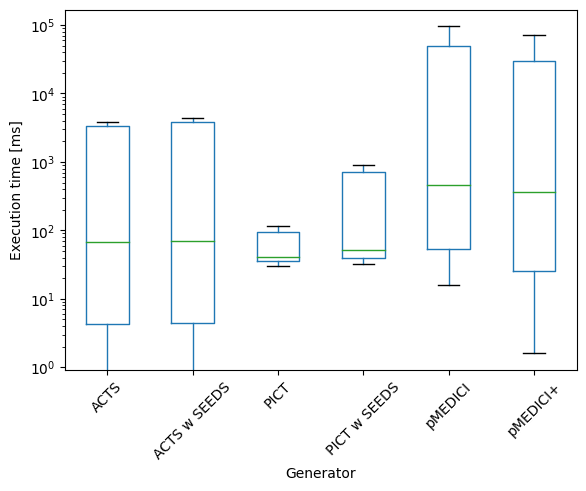

In [10]:
# Extract the execution time of different generators
dfExecutionTime = dfFiltered[['Generator','TSTime']]

# Boxplot the execution time of different generators and remove the outliers
ax = dfExecutionTime.boxplot(by='Generator', showfliers=False, grid=False, rot=45)
ax.set_yscale('log')
ax.set_ylabel('Execution time [ms]')
ax.set_xlabel('Generator')
ax.set_title('')
plt.suptitle('')

In [15]:
# Execute a Wilcoxon Signed-Rank test among each couple of Generators investigating the TSTime
from scipy.stats import wilcoxon
from itertools import combinations
generators = dfExecutionTime['Generator'].unique()
for generator1, generator2 in combinations(generators, 2):
    print(generator1 + " VS " + generator2 + ":\n", wilcoxon(dfExecutionTime[dfExecutionTime['Generator'] == generator1]['TSTime'], dfExecutionTime[dfExecutionTime['Generator'] == generator2]['TSTime']))

ACTS VS ACTS w SEEDS WilcoxonResult(statistic=111.5, pvalue=0.004345025484754507)
ACTS VS PICT WilcoxonResult(statistic=365.0, pvalue=0.12923511881504018)
ACTS VS PICT w SEEDS WilcoxonResult(statistic=384.0, pvalue=0.28252215647494205)
ACTS VS pMEDICI WilcoxonResult(statistic=280.0, pvalue=0.012104215953983533)
ACTS VS pMEDICI+ WilcoxonResult(statistic=304.0, pvalue=0.025812191225012344)
ACTS w SEEDS VS PICT WilcoxonResult(statistic=360.0, pvalue=0.11514352150123057)
ACTS w SEEDS VS PICT w SEEDS WilcoxonResult(statistic=428.0, pvalue=0.5868731085604295)
ACTS w SEEDS VS pMEDICI WilcoxonResult(statistic=281.0, pvalue=0.012510026205973464)
ACTS w SEEDS VS pMEDICI+ WilcoxonResult(statistic=308.0, pvalue=0.02908548066460407)
PICT VS PICT w SEEDS WilcoxonResult(statistic=188.5, pvalue=0.0003472698376027488)
PICT VS pMEDICI WilcoxonResult(statistic=121.5, pvalue=1.307231190184465e-05)
PICT VS pMEDICI+ WilcoxonResult(statistic=227.0, pvalue=0.0017623289466845572)
PICT w SEEDS VS pMEDICI Wilcox

c:\Users\Andrea_PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


## Size analysis

Text(0.5, 0.98, '')

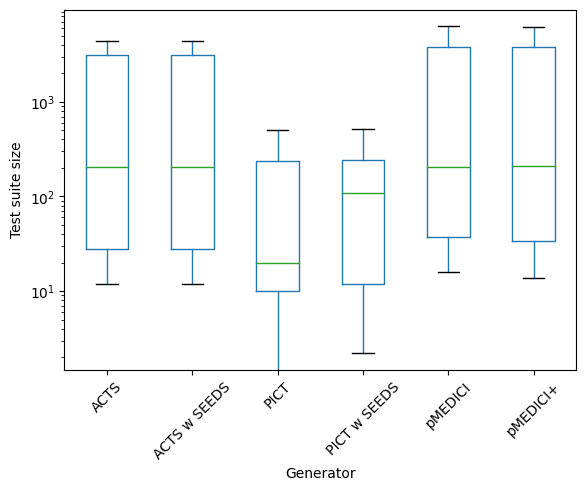

In [11]:
# Extract the TS Size of different generators
dfTSSize = dfFiltered[['Generator','TSSize']]

# Boxplot the TS Size of different generators and remove the outliers
ax = dfTSSize.boxplot(by='Generator', showfliers=False, grid=False, rot=45)
ax.set_yscale('log')
ax.set_ylabel('Test suite size')
ax.set_xlabel('Generator')
ax.set_title('')
plt.suptitle('')